*This is my first submission in a Kaggle competition. Let me know about your suggestions on improving this notebook. Thank you.*

### My Submission:

* Private Score: **0.899958**

* Public Score: **0.922061**

# 1. Importing Packages and Libraries

In [30]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import missingno as msno
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb

from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import gc

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

The below function is adapted from [Konstantin](https://www.kaggle.com/kyakovlev/ieee-data-minification)'s approach.

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# 2. Importing Data and Reducing Memory Usage

In [3]:
train_identity = pd.read_csv("../input/ieee-fraud-detection/train_identity.csv")
train_transaction = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv")

test_identity = pd.read_csv("../input/ieee-fraud-detection/test_identity.csv")
test_transaction = pd.read_csv("../input/ieee-fraud-detection/test_transaction.csv")

train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)
test_identity = reduce_mem_usage(test_identity)
test_transaction = reduce_mem_usage(test_transaction)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)


In [4]:
print(train_transaction.info(), "\n")
print(train_identity.info(), "\n")
print(test_transaction.info(), "\n")
print(test_identity.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float16(332), float32(44), int16(1), int32(2), int8(1), object(14)
memory usage: 542.3+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int32
id_01            144233 non-null float16
id_02            140872 non-null float32
id_03            66324 non-null float16
id_04            66324 non-null float16
id_05            136865 non-null float16
id_06            136865 non-null float16
id_07            5155 non-null float16
id_08            5155 non-null float16
id_09            74926 non-null float16
id_10            74926 non-null float16
id_11            140978 non-null float16
id_12            144233 non-null object
id_13            127320 non-null float16
id_14            80044 non-null float16
id_15            140985 non-null object
id_16            1

# 3. Solving Column Mismatch

In [5]:
def differentcolumns(traincols, testcols):
    for i in traincols:
        if i not in testcols:
            print(i)
            
differentcolumns(train_identity.columns, test_identity.columns) 

id_01
id_02
id_03
id_04
id_05
id_06
id_07
id_08
id_09
id_10
id_11
id_12
id_13
id_14
id_15
id_16
id_17
id_18
id_19
id_20
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_28
id_29
id_30
id_31
id_32
id_33
id_34
id_35
id_36
id_37
id_38


In [6]:
test_identity = test_identity.rename(columns={"id-01": "id_01", "id-02": "id_02", "id-03": "id_03",
                             "id-06": "id_06", "id-05": "id_05", "id-04": "id_04",
                             "id-07": "id_07", "id-08": "id_08", "id-09": "id_09",
                             "id-10": "id_10", "id-11": "id_11", "id-12": "id_12",
                             "id-15": "id_15", "id-14": "id_14", "id-13": "id_13",
                             "id-16": "id_16", "id-17": "id_17", "id-18": "id_18",
                             "id-21": "id_21", "id-20": "id_20", "id-19": "id_19",
                             "id-22": "id_22", "id-23": "id_23", "id-24": "id_24",
                             "id-27": "id_27", "id-26": "id_26", "id-25": "id_25",
                             "id-28": "id_28", "id-29": "id_29", "id-30": "id_30",
                             "id-31": "id_31", "id-32": "id_32", "id-33": "id_33",
                             "id-34": "id_34", "id-35": "id_35", "id-36": "id_36",
                             "id-37": "id_37", "id-38": "id_38"})
test_identity.head() 

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [7]:
differentcolumns(train_identity.columns, test_identity.columns) 

# 4. Joining Transaction and Identity Data:

In [8]:
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [9]:
del train_identity, train_transaction, test_identity, test_transaction

# 5. Data Engineering

## 5.1. Different Data Types

In [10]:
#train.info(verbose=True, null_counts=True)
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,...,139369.0,4.511300e+04,139318.0,139261.0,5159.0,5169.000000,4747.000000,5132.0000,5163.00000,77586.0
mean,3.282270e+06,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,inf,inf,12.820312,inf,inf,NaN
std,1.704744e+05,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,...,0.0,1.561523e+00,NaN,NaN,inf,6.898438,2.373047,97.4375,32.09375,0.0
min,2.987000e+06,0.000000,8.640000e+04,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,...,100.0,1.000000e+01,100.0,100.0,100.0,10.000000,11.000000,100.0000,100.00000,0.0
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,...,166.0,1.300000e+01,266.0,256.0,252.0,14.000000,11.000000,321.0000,119.00000,24.0
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,...,166.0,1.500000e+01,341.0,472.0,252.0,14.000000,11.000000,321.0000,149.00000,24.0
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,...,225.0,1.500000e+01,427.0,533.0,486.5,14.000000,15.000000,371.0000,169.00000,32.0
max,3.577539e+06,1.000000,1.581113e+07,31936.000000,18396.000000,600.0,231.0,237.0,540.0,102.0,...,229.0,2.900000e+01,671.0,661.0,854.0,44.000000,26.000000,548.0000,216.00000,32.0


The dataset description below is provided by the competition host [here](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-605862).

### Transaction Table
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

### Identity Table

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
* DeviceType
* DeviceInfo
* id_12 - id_38

## 5.2. Looking at Missing Data

Function for counting missing values

In [11]:
def getnulls(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
    return missing_data

In [12]:
#Train data missing values
missing_data_train = getnulls(train)
missing_data_train.head(350).T 

,id_24,id_25,id_07,id_08,id_21,id_26,id_22,id_23,id_27,dist2,...,V96,V106,V114,V113,V112,V111,V110,V109,V108,V107
total,585793.000000,585408.00000,585385.000000,585385.000000,585381.000000,585377.000000,585371.000000,585371.000000,585371.000000,552913.000000,...,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
percent,0.991962,0.99131,0.991271,0.991271,0.991264,0.991257,0.991247,0.991247,0.991247,0.936284,...,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532


In [13]:
# Test Data Missing Values
missing_data_test = getnulls(test)
missing_data_test.head(350).T 

,id_24,id_25,id_26,id_07,id_08,id_21,id_27,id_22,id_23,dist2,...,C2,C9,V292,V291,V290,C10,V286,V287,V294,V285
total,501951.000000,501652.000000,501644.000000,501632.000000,501632.000000,501632.000000,501629.00000,501629.00000,501629.00000,470255.00000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
percent,0.990645,0.990055,0.990039,0.990016,0.990016,0.990016,0.99001,0.99001,0.99001,0.92809,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006


# 6. Feature  Engineering

We have lot of NAN values present in our data. Taking all columns is unneccessary. Removing columns with high coorelation makes our model more fast and accurate.

### How to reduce number of columns based on number of NaN values and coorelation:
Group columns based on number of missing values Eg. if there are 4 columsn v1,v2,v3 and v4. If v1 and v3 have 56 missing values and v2 have 21 and v4 have 5 missing values, we have 3 groups ['v1','v3'] , ['v2'] and ['v4']
For each group: 2.1] For each column in that group find the coorelation with other columns and take only columns with coorelation coeffcient > 0.75

2.2] Take the largest list with common elemnts as a subgroup.Each group contains several subgroups
For eg: if we have [[v1,v2],[v6],[v1,v4,v2,v5],[v5,v4]] ,our output will be [[v1,v2,v4,v5],[v6]]

2.3] Now from each subgroups choose the column with most number of unique values.

For eg, in subgroup [v1,v2,v4,v5], let v2 have most unique values so our output becomes
[v2,v6]

In [14]:
def top_missing_cols(df,n=10,thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [15]:
df_missing = top_missing_cols(train,n=None,thresh=50)
# Taking all column with missing percentage over the value of 50%
missing_cols = df_missing['col']

There are 414 columns in this dataset with missing values.
There are 214 columns with missing percent values than 50%


In [16]:
# I will take all columns and group them based on missing percentage
nan_dict = {}
for col in missing_cols:
    count = train[col].isnull().sum()
    try:
        nan_dict[count].append(col)
    except:
        nan_dict[count] = [col]
        
for k,v in nan_dict.items():
    print(f'#####' * 4)
    print(f'NAN count = {k} percent: {(int(k)/train.shape[0])*100} %')
    print(v)

####################
NAN count = 585793 percent: 99.19615944728554 %
['id_24']
####################
NAN count = 585408 percent: 99.13096487960172 %
['id_25']
####################
NAN count = 585385 percent: 99.12707013919464 %
['id_07', 'id_08']
####################
NAN count = 585381 percent: 99.12639279303687 %
['id_21']
####################
NAN count = 585377 percent: 99.12571544687913 %
['id_26']
####################
NAN count = 585371 percent: 99.1246994276425 %
['id_27', 'id_23', 'id_22']
####################
NAN count = 552913 percent: 93.62837403054831 %
['dist2']
####################
NAN count = 551623 percent: 93.40992989467267 %
['D7']
####################
NAN count = 545427 percent: 92.36072069631184 %
['id_18']
####################
NAN count = 528588 percent: 89.50926270870728 %
['D13']
####################
NAN count = 528353 percent: 89.46946862193924 %
['D14']
####################
NAN count = 525823 percent: 89.04104717715988 %
['D12']
####################
NAN count = 52

In [17]:
def coorelation_analysis(cols,title='Coorelation Analysis',size=(12,12)):
    cols = sorted(cols)
    fig,axes = plt.subplots(1,1,figsize=size)
    df_corr = train[cols].corr()
    sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
    axes.title.set_text(title)
    plt.show()

In [18]:
def reduce_groups(grps):
    '''
    determining columns that have more unique values among a group of atttributes
    '''
    use = []
    for col in grps:
        max_unique = 0
        max_index = 0
        for i,c in enumerate(col):
            n = train[c].nunique()
            if n > max_unique:
                max_unique = n
                max_index = i
        use.append(col[max_index])
    return use

In [19]:
# column details
cat_cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['M%d' % i for i in range(1, 10)] + 
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])


type_map = {c: str for c in cat_cols}
train[cat_cols] = train[cat_cols].astype(type_map, copy=False)
test[cat_cols] = test[cat_cols].astype(type_map, copy=False)

######################################################################################

id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

numeric_cols =  [
    'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
    'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 
    'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 
    'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 
    'id_09', 'id_10', 'id_11'
]


reduced_vcols = ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 
 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 
 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96', 
 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 
 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162', 'V165', 'V160', 'V166', 'V178',
 'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215', 'V169', 'V171', 'V175', 'V180', 'V185', 
 'V188', 'V198', 'V210', 'V209', 'V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235', 'V240', 'V258', 
 'V257', 'V253', 'V252', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274', 'V277', 'V220', 'V221', 'V234', 
 'V238', 'V250', 'V271', 'V294', 'V284', 'V285', 'V286', 'V291',
 'V297', 'V303', 'V305', 'V307', 'V309', 'V310', 'V320', 'V281', 'V283', 'V289', 'V296', 'V301', 'V314', 'V332', 'V325', 'V335', 'V338']

In [20]:
# droping v cols as they are highly correlated 
drop_cols = [col for col in train.columns if col[0] == 'V' and col not in reduced_vcols]

print(f'dropping {len(drop_cols)} columns')
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

dropping 211 columns


# 7. Data Splitting for Training

In [21]:
## Train and test split¶
y_train = train['isFraud']
X_train = train.drop(columns=['isFraud'])
X_test = test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()

(590540, 222)
(506691, 222)


63

# 8. Feature Encoding

In [22]:
# Label encoding all categorical features
for col in X_train.columns:
    
    if col in cat_cols:
        # label encode all categorical columns
        dff = pd.concat([X_train[col],X_test[col]])
        dff,_ = pd.factorize(dff,sort=True)
        if dff.max()>32000: 
            print(col,'needs int32 datatype')
            
        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')

In [23]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID'])

cols = [col for col in X_train.columns if col not in rem_cols]
len(cols)

220

In [24]:
# Scaling numeric features
for col in cols:
    if col not in cat_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff

### Using garbage collector to clear memory

In [25]:
gc.collect()

28

# 9. Training

In [28]:
x_train = X_train[cols]
x_test = X_test[cols]


idx_train = x_train.index[:int(x_train.shape[0]*0.75)]  
idx_validation = x_train.index[int(x_train.shape[0]*0.75):]
    
print(f'fitting model on {len(cols)} columns')
clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
          )
model = clf.fit(x_train.loc[idx_train,cols], y_train[idx_train], 
            eval_set=[(x_train.loc[idx_validation,cols],y_train[idx_validation])],
            verbose=50, early_stopping_rounds=100)

fitting model on 220 columns
[0]	validation_0-auc:0.814096
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.869264
[100]	validation_0-auc:0.880498
[150]	validation_0-auc:0.891717
[200]	validation_0-auc:0.900622
[250]	validation_0-auc:0.908036
[300]	validation_0-auc:0.913535
[350]	validation_0-auc:0.917386
[400]	validation_0-auc:0.920008
[450]	validation_0-auc:0.921415
[500]	validation_0-auc:0.922505
[550]	validation_0-auc:0.922883
[600]	validation_0-auc:0.923135
[650]	validation_0-auc:0.922915
Stopping. Best iteration:
[599]	validation_0-auc:0.923162



In [31]:
y_train_pred = model.predict(x_train.iloc[idx_train])
y_test_pred = model.predict(x_train.iloc[idx_validation])

train_fpr, train_tpr, thresholds = roc_curve(y_train.iloc[idx_train], model.predict_proba(x_train.iloc[idx_train])[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_train.iloc[idx_validation], model.predict_proba(x_train.iloc[idx_validation])[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Area under train roc 0.9933914212196606
Area under test roc 0.9231615454614862


# 10. Confusion Matrix After Training

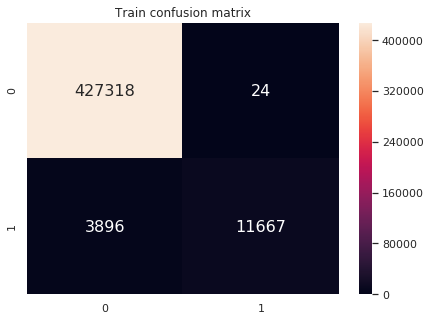

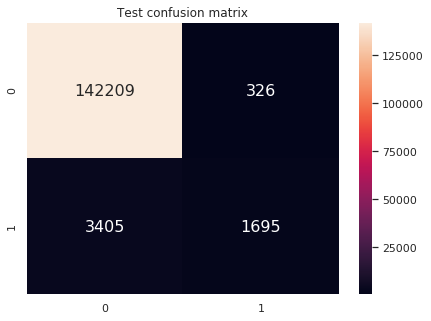

In [32]:
train_cf = confusion_matrix(y_train.iloc[idx_train],y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


cv_cf = confusion_matrix(y_train.iloc[idx_validation],y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

# 11. Creating Submission File

In [36]:
y_pred_test = model.predict_proba(x_test)[:,1]
submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
submission['isFraud'] = y_pred_test
submission.to_csv('../submission_xgboost_gpu.csv',index=False)

References:
1. https://www.kaggle.com/kabure/almost-complete-feature-engineering-ieee-data
2. https://www.kaggle.com/artgor/eda-and-models

### Future Improvements:
1. Handling Target Class Imbalance
2. More EDA
3. More In-depth Feature Engineering
4. Application of Ensemble Method